In [1]:
import popy as popy
from popy.data_fakers.soep import soep_faker
from popy.pop_maker import PopMaker

import pandas as pd
import random
import matplotlib.pyplot as plt

import datetime as dt

In [2]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)

        self.infection_status = "susceptible"
        self.days_since_infection = 0
    

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for location in self.locations:
                for agent_v in location.neighbors(self):
                    if agent_v is not self:
                        if agent_v.infection_status == "susceptible":
                            visit_weight_v = location.visit_weights[agent_v.id]
                            visit_weight_u = location.visit_weights[self.id]
                            
                            contact_weight = (visit_weight_u * visit_weight_v) / (24 * 24)
                            

                            infection_probability = self.model.p.infection_weight * contact_weight
                            
                            if random.random() < infection_probability:
                                agent_v.infection_status = "exposed"
    

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"
            
            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"
            
            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [3]:
class Home(popy.Location):
    def setup(self):
        self.is_home = True

    def groupby(self, agent):
        return agent.hid


class Work(popy.Location):
    def setup(self):
        self.size = 10
    
    def can_affiliate(self, agent):
        return agent.work_hours_day > 0

    def get_visit_weight(self, agent):
        return agent.work_hours_day


class School(popy.Location):
    def setup(self):
        self.size = 25
    
    def can_affiliate(self, agent) -> bool:
        return 6 <= agent.age <= 18
    
    def get_visit_weight(self, agent):
        return 6
    
    def can_visit(self, agent):
        # evtl. braucht man Location.can_visit() gar nicht, weil man das Besuchsgewicht ja auch einfach über Location.get_visit_weight() auf 0 setzen könnte .... ?
        
        visit = False
        
        # workday?
        if agent.model.date.weekday() < 5:
            # not ill?
            if agent.infection_status != "symptomatic" or agent.infection_status == "symptomatic" and random.random() < 0.5:
                # no holidays?
                if random.random() < self.model.get_timetable_entry()["school"]:
                    visit = True
    
        return visit


    def count_current_infections(self):
        n_symptomatic = sum([agent.infection_status == "symptomatic" for agent in self.agents])


class Friendship(popy.Location):
    def setup(self):
        self.size = 2
    
    def groupby(self, agent):
        return (abs(agent.age + random.randint(-5,5)), agent.gender)
    
    def get_visit_weight(self, agent):
        return 2
    
    def can_visit(self, agent):
        return agent.model.date.weekday() >= 5

In [4]:
class Model(popy.Model):
    
    def setup(self):
        df_soep = soep_faker.soep(size=self.p.n_agents)
        
        self.pop_maker = PopMaker(model=self)
        
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(agents=self.agents, location_classes=[Home, School, Work, Friendship])
        
        self.infection_list = []
        self.date = dt.date(2020, 1, 1)

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"
        

        self.timetable = {
            dt.date(2020, 1, 1): {
                "school": 1,
            },
            dt.date(2020, 2, 1): {
                "school": 0,
            },
            dt.date(2020, 2, 15): {
                "school": 1,
            }
        }

    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()
        
    def update(self):
        self.record("cumulative_infections", sum([1 for agent in self.agents if agent.infection_status != "susceptible"]))
        self.date = self.date + dt.timedelta(days=1)
    
    def get_timetable_entry(self):
        for date_key in self.timetable:
            if date_key <= self.date:
                entry = self.timetable[date_key]
        return entry


Completed: 50 steps
Run time: 0:00:00.505041
Simulation finished


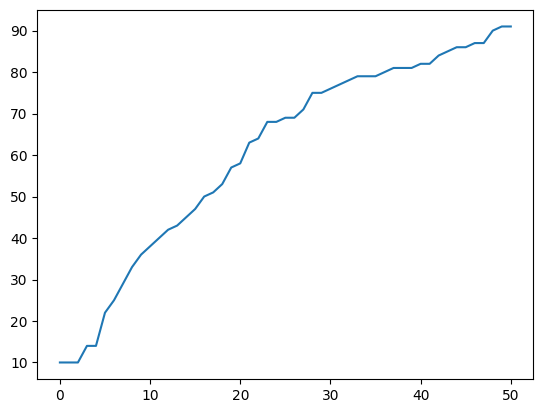

In [5]:
parameters = {
    "steps": 50,
    "n_agents": 1000,
    "infection_weight": 0.1,
}
model = Model(parameters=parameters)

results = model.run()

plt.plot(results.variables.Model.cumulative_infections)

In [6]:
model.pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                                   
                  count       mean       std   min   25%   50%   75%   max
location_class                                                            
Friendship        517.0   1.922631  0.522563   0.0   2.0   2.0   2.0   3.0
Home              308.0   3.246753  1.566388   1.0   2.0   3.0   4.0   9.0
School              3.0  28.000000  1.732051  27.0  27.0  27.0  28.5  30.0
Work               43.0   9.953488  0.304997   8.0  10.0  10.0  10.0  10.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    1000.000000
mean        2.506000
std         1.045494
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: n_affiliated_locations, dtype: float64
